In [278]:
import numpy as np 
import matplotlib.pyplot as plt

In [279]:
angle,time,time_str = [],[],[]
with open('angle_time.csv', 'r') as f:
    line = f.readline() 
    while line: 
        a,ts = line.split(',')
        h,m = ts.split(':')
        t = int(h)*60 + int(m)

        angle.append(float(a))
        time.append(t)
        time_str.append(ts)

        line = f.readline() 

angles = np.array(angle)
times = np.array(time) 
times = times - times.min()
times = times / times.max()

In [280]:
NIGHT = 102
END_SUNRISE = 94
DAY = 80

MAX_VAL = 200
VAL_MIN = 128
SAT_MIN = 96


HUE_POLY = 1.5
SAT_POLY = 2
VAL_POLY = 0.5

GREEN_START = (45+255)
GREEN_OFFSET = 85

STOP_HUE_CHANGE = (NIGHT - END_SUNRISE) / (NIGHT - DAY)

# Blue, Purple, Pink, Red
starting_hues = np.array([180,200,210,160])
# Blue, Pink, Orange, Gold
ending_hues = np.array([135, 145, 256+45, 256+40])

N_COLORS = starting_hues.shape[0]

# Convert from angle to percent
percents = (NIGHT-angles) / (NIGHT-DAY)
percents[percents < 0] = 0;percents

array([1.        , 0.99545455, 0.99090909, 0.98636364, 0.98181818,
       0.97727273, 0.97272727, 0.96818182, 0.96363636, 0.95909091,
       0.95454545, 0.95      , 0.94545455, 0.94090909, 0.93636364,
       0.93181818, 0.92727273, 0.92272727, 0.91818182, 0.91363636,
       0.90909091, 0.90454545, 0.9       , 0.89545455, 0.89090909,
       0.88636364, 0.88181818, 0.87727273, 0.87272727, 0.86818182,
       0.86363636, 0.85909091, 0.85454545, 0.85      , 0.84545455,
       0.84090909, 0.83636364, 0.83181818, 0.82727273, 0.82272727,
       0.81818182, 0.81363636, 0.80909091, 0.80454545, 0.8       ,
       0.79545455, 0.79090909, 0.78636364, 0.78181818, 0.77727273,
       0.77272727, 0.76818182, 0.76363636, 0.75909091, 0.75454545,
       0.75      , 0.74545455, 0.74090909, 0.73636364, 0.73181818,
       0.72727273, 0.72272727, 0.71818182, 0.71363636, 0.70909091,
       0.70454545, 0.7       , 0.69545455, 0.69090909, 0.68636364,
       0.68181818, 0.67727273, 0.67272727, 0.66818182, 0.66363

In [281]:
import matplotlib.colors as mcolors

def draw_rectangle_gradient(ax, x1, y1, width, height, color1, color2, n=100):
    # Create an array of the linear gradient between the two colors
    gradient_colors = []
    for segment in np.linspace(0, width, n):
        interp_color = [(1 - segment / width) * color1[j] + (segment / width) * color2[j] for j in range(3)]
        if interp_color[0] > 1: 
            interp_color[0] -= 1

        gradient_colors.append(mcolors.hsv_to_rgb(interp_color))
    for i, color in enumerate(gradient_colors):
        ax.add_patch(plt.Rectangle((x1 + width/n * i, y1), width/n, height, color=color, linewidth=0, zorder=0))
    return ax

def green_filter(h): 
    filter_after = 0
    for h_ in h: 
        if h_ > GREEN_START:
            break 
        filter_after += 1 

    h[filter_after:] += GREEN_OFFSET

In [282]:
from math import sin
H=0; S=1; V=2
def update_leds(percent):  
    arr = [[0,0,0] for _ in range(N_COLORS)]

    s = ((255-SAT_MIN) * (1-pow(percent, SAT_POLY))) + SAT_MIN; 
    v = (MAX_VAL-VAL_MIN) * pow(percent, VAL_POLY)
    v = v+VAL_MIN if (percent != 0) else v
    
    percent = min(percent, STOP_HUE_CHANGE) / STOP_HUE_CHANGE; 
    for i in range(N_COLORS): 
        h = starting_hues[i] 
        hue_change = ending_hues[i] - starting_hues[i]
        #h += (pow(percent, HUE_POLY[i]) * hue_change)
        
        h += (pow(percent, HUE_POLY) * hue_change)

        #if (h > GREEN_START):
        #    h += GREEN_OFFSET

        arr[i][H] = h; 
        arr[i][S] = s; 
        arr[i][V] = 255; 

    arr = np.array(arr, dtype=np.float16)
    arr %= 256 
    arr /= 255
    return arr

def get_val(percent): 
    v = (MAX_VAL-VAL_MIN) * sin(percent)
    v = v+VAL_MIN
    return v

def get_hue(percent): 
    percent = min(percent, STOP_HUE_CHANGE) / STOP_HUE_CHANGE; 
    arr = [0] * N_COLORS
    for i in range(N_COLORS): 
        h = starting_hues[i] 
        hue_change = ending_hues[i] - starting_hues[i]
        #h += (pow(percent, HUE_POLY[i]) * hue_change)
        
        h = (pow(percent, HUE_POLY) * hue_change)

        #if (h > GREEN_START):
        #    h += GREEN_OFFSET

        arr[i] = h; 

    arr = np.array(arr, dtype=np.float16)
    arr %= 256 
    arr /= 255
    return arr

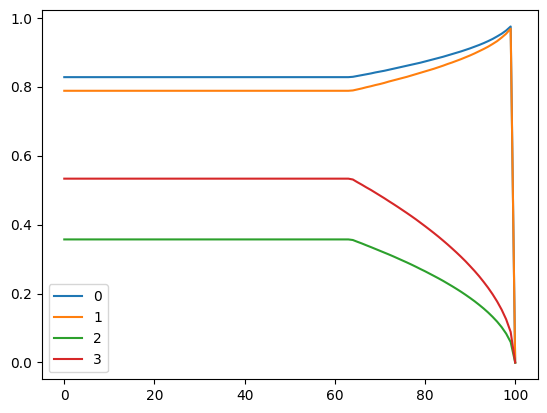

In [283]:
HUE_POLY = 0.5
lines = []
for i in range(100,-1,-1): 
    lines.append(get_hue(i/100))

plt.plot(lines, label=[0,1,2,3])
plt.legend()
plt.show()

In [284]:
HUE_POLY=0.75
SAT_POLY=1

[135 145  45  40]
[135.5  145.6   45.2   40.16]
[170.5 188.4 231.4 191.5]
[180 200 210 160]


C:\Users\The-Jabberwock\AppData\Local\Temp\ipykernel_39664\2298301006.py:7: RuntimeWarning: invalid value encountered in scalar divide
  interp_color = [(1 - segment / width) * color1[j] + (segment / width) * color2[j] for j in range(3)]
c:\Users\The-Jabberwock\anaconda3\envs\arduino\Lib\site-packages\matplotlib\colors.py:3175: RuntimeWarning: invalid value encountered in cast
  i = (h * 6.0).astype(int)


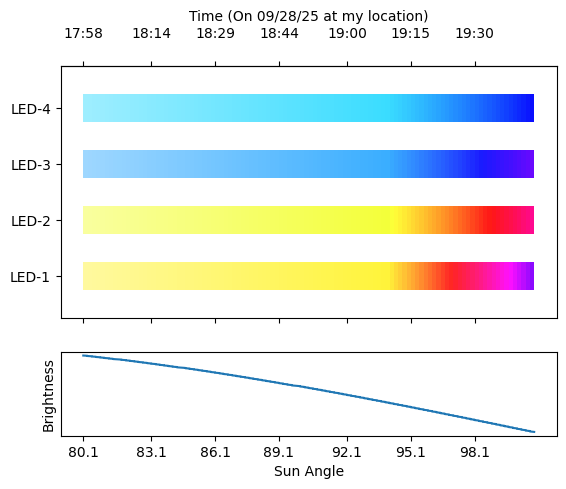

In [285]:
n = len(time_str)
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios': [3, 1]},)

print(ending_hues % 256)
ax = axes[0]
for i in range(times.shape[0]-1): 
    c1 = update_leds(percents[i])
    c2 = update_leds(percents[i+1])

    if i == 0: 
        print(c1[:,0] * 256)

    for j in range(N_COLORS): 
        draw_rectangle_gradient(ax, times[i], 3-j, times[i+1]-times[i], 0.5, c1[j], c2[j], n=1)

vals = [get_val(p) for p in percents[1:]]

print(c2[:,0] * 256)
print(starting_hues)

SKIP = 30
ax.set_ylim(-0.5, len(starting_hues))
ax.set_xticks(times[1::SKIP], [p for p in angles[1::SKIP]])
ax_top = ax.secondary_xaxis('top')
ax_top.set_xticks(times[1::SKIP], time_str[1::SKIP])
ax_top.set_xlabel("Time (On 09/28/25 at my location)")
ax.set_yticks([0.25+i for i in range(4)], [f'LED-{i+1}' for i in range(4)])

v_ax = axes[1]
v_ax.plot(times[1:], vals)
v_ax.set_ylabel('Brightness')
v_ax.set_yticks([])
v_ax.set_xlabel("Sun Angle")

plt.show()